# Testing for ideas

In [32]:
# samples = os.listdir(DATA_DIR)

# testsample = samples[0]
# image_dir = os.path.join(DATA_DIR, testsample, 'Raw')
# mask_dir = os.path.join(DATA_DIR, testsample, 'Mask')

# nuc_img = mpl.pyplot.imread(os.path.join(image_dir, 'nuclei.tiff'))
# nuc_img = rescale_intensity(nuc_img, (100, 400)) # need to manually set the intensity range
# nuc_img = nuc_img[600:nuc_img.shape[0], 0:600]

# nuc_cvseg = segmentation.chan_vese(nuc_img, mu=0.25, lambda1=1, lambda2=1, tol=1e-3,
#                max_num_iter=200, dt=0.5, init_level_set="checkerboard",
#                extended_output=True)

# fig, axes = mpl.pyplot.subplots(1, 2, figsize=(8, 5))
# ax = axes.flatten()

# ax[0].imshow(nuc_img, cmap="gray")
# ax[0].set_axis_off()
# ax[0].set_title("Original Image", fontsize=12)

# ax[1].imshow(nuc_cvseg[0])
# ax[1].set_axis_off()
# title = f'Chan-Vese segmentation'
# ax[1].set_title(title, fontsize=12)

In [31]:
# nuc_mask = mpl.pyplot.imread(os.path.join(mask_dir, 'mask.tiff'))
# nuc_mask = nuc_mask[600:nuc_mask.shape[0], 0:600]

# fig, axes = mpl.pyplot.subplots(1, 2, figsize=(8, 5))
# ax = axes.flatten()

# ax[0].imshow(nuc_img, cmap="gray")
# ax[0].set_axis_off()
# ax[0].set_title("Original Image", fontsize=12)

# ax[1].imshow(nuc_mask, cmap='gray')
# ax[1].set_axis_off()
# ax[1].set_title('mask', fontsize=12)

## Evolve curve around an object

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, laplace
from skimage.io import imshow, imsave, imread
from skimage.draw import disk, circle_perimeter
import matplotlib as mpl
import os
import cv2 as cv

%matplotlib inline

In [2]:
ROOT = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT, 'Data')

In [71]:
x = np.zeros((3,3))
np.vstack((np.zeros((1,3)),x))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [96]:
# Initialize a guesss of the contour
def initialize(img):
    '''
    Distance transforming image into a family of level sets psi = +/-d
    The psi = 0 level always yields the moving front of a shape, aka the curvature
    '''
    img = np.clip(img, 0, 255)
    img_invert = 255 - img # this step will change boundaries to 0
    img = img.astype('uint8')
    img_invert = img_invert.astype('uint8')
    # conver to single-channgle gray-scale image
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
    zero_level = np.zeros_like(img)
    img_invert = cv.cvtColor(img_invert, cv.COLOR_BGR2GRAY)
    # distance transform the image with a 3 x 3 kernel. 
    dist_img = cv.distanceTransform(img, cv.DIST_L2, 3) 
    img_invert[dist_img==dist_img.max()] = 255 # need to restore the boundaries
    dist_img_invert = cv.distanceTransform(img_invert, cv.DIST_L2, 3) 
    psi = dist_img + dist_img_invert 
    # imshow(res_img)
    zero_level[psi == psi.min()] = 1
    # imshow(psi)
    # mark boundaries in dist_img with 0, then make the interior distance negative 
    # dist_img[zero_level > 0] = 0 # we want the distance on the boundaries to be zero
    dist_img = -1 * dist_img # the distances inside the boundaries are negative
    # dist_img_invert[zero_level > 0] = 0 # we want the distance on the boundaries to be zero
    psi = dist_img + dist_img_invert # now the boundaries are fixed and zero
    return zero_level, psi

def draw_curve(img, psi, color_vec=[255,0,0]):
    '''
    Draw curve U on an image. By default, it is drawn in the red channel
    '''
    min_value = np.min(np.abs(psi)) # take the min to be the zero level set because of numerical issue
    img[psi==min_value] = color_vec
    return img

def curve_evolution(img, dt=0.5, max_iter=1000, v=0.2):
    '''
    evolve the curve based on the magitude the image gradient 
    u(t) = v dU/dt, where v is a velocity determined by the image gradient
    '''
    # TODO: should change this to curve = min(abs(I))
    curve, psi = initialize(img) # initialize psi and curve
    dx, dy = np.gradient(psi) # central differences of psi in curvature motion flow
    # imshow(psi)
    grad_mag = np.sqrt(dx**2 + dy**2)
    for i in range(max_iter):
        dpsi = v * grad_mag * dt
        psi[:] = psi[:] - dpsi
    imshow(psi)
    # img = draw_curve(img, psi)
    return
    

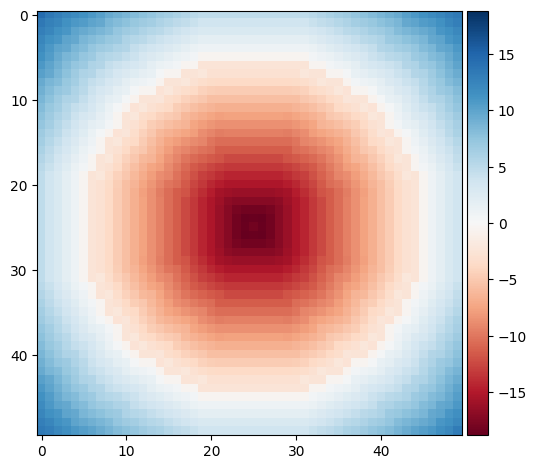

In [107]:
img = imread(os.path.join(DATA_DIR, 'example', 'test.png'))
# U = initialize((img.shape[0],img.shape[1]), r=15)
# dist_transformed_img = distance_transform(img, sigma=2)
curve_evolution(img, max_iter=10)